In [57]:
'''
Code loads data from oviraptor catalogue.  The goal is to generate a bootstrap sample of transit stellar hosts that has 
the same distribution of masses as the RV systems.  A p-chip spline is fitted to the RV distribution in order to create a 
probability distribution (cdf).  We draw weighted samples from the transit population with weights defined by the spline
cdf.  For each transiting planet, we draw probabilistic values using Chen and Kipping's mass forecaster.  The masses, radii,
and corresponding uncertainties are used as starting points for the process.  After calculating system-level parameters (Q,
mu, S, C, etc.), we perform KS and AD tests on each statistic and record their p-values.  Finally, for each statistic, 
we determine the proportion of trials the null hypothesis is rejected and the proportion that the null hypothesis is 
accepted.
'''

"\nCode loads data from oviraptor catalogue.  The goal is to generate a bootstrap sample of transit stellar hosts that has \nthe same distribution of masses as the RV systems.  A p-chip spline is fitted to the RV distribution in order to create a \nprobability distribution (cdf).  We draw weighted samples from the transit population with weights defined by the spline\ncdf.  For each transiting planet, we draw probabilistic values using Chen and Kipping's mass forecaster.  The masses, radii,\nand corresponding uncertainties are used as starting points for the process.  After calculating system-level parameters (Q,\nmu, S, C, etc.), we perform KS and AD tests on each statistic and record their p-values.  Finally, for each statistic, \nwe determine the proportion of trials the null hypothesis is rejected and the proportion that the null hypothesis is \naccepted.\n"

In [58]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import LMC
import archinfo

import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy import stats
from scipy.optimize import curve_fit

import dcor
import random
import collections
import importlib as imp
from KDEpy import FFTKDE

import sys
sys.path.insert(0, "./forecaster/")
import mr_forecast as mr

import time
from timeit import default_timer


# define a few constants
pi = np.pi

MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

In [59]:
# set manual controls and paths
NBOOT = 100

my_file = 'C:/Users/djhoo/Documents/Oviraptor-master/catalogues/oviraptor_master.csv'
#my_file = "/Users/research/projects/oviraptor/catalogues/oviraptor_master.csv"

In [60]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [61]:
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [62]:
# now make the data dictionary
d = {}
d['starname'] = get_key('Starname')
d['rp'] = get_key('Rp')
d['rerr1'] = get_key('R_lower')
d['rerr2'] = get_key('R_upper')
d['mp'] = get_key('Mp')
d['merr1'] = get_key('M_lower')
d['merr2'] = get_key('M_upper')
d['ms'] = get_key('Ms')
d['rs'] = get_key('Rs')
d['p'] = get_key('P')

# disc_method can vary within a system (i.e. discovery method for each planet)
d['disc_method'] = get_key('Detection Method')

#'sys_disc_method' should be the same for all planets in a given system
d['sys_disc_method'] = get_key('System Detection Method')

In [63]:
# convert numerical quantities to floats; set missing values to np.nan
for k in d.keys():
    if (k[-11:] != "disc_method")*(k != "starname"):
        
        arr = np.zeros(len(d["starname"]))

        for i, entry in enumerate(d[k]):
            if entry == "":
                arr[i] = np.nan
            else:
                arr[i] = float(entry)
                
        d[k] = np.copy(arr)

In [64]:
# count up the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 842 objects in 239 systems remain


In [65]:
# removes planets missing both a mass and radius (must have at least one)
bad = np.isnan(d["mp"]) * np.isnan(d["rp"])

print("Removed planets with neither mass nor radius from the following systems")
for star in np.unique(d["starname"][bad]):
    print(star)
    
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

Removed planets with neither mass nor radius from the following systems
Kepler-37

After removals, 841 objects in 239 systems remain


In [66]:
# remove systems with missing stellar mass or radius
bad = np.isnan(d["ms"]) + np.isnan(d["rs"])


print("Removed the following systems with missing Mstar or Rstar")
for star in np.unique(d["starname"][bad]):
    print(star)   
    
for k in d.keys():
    d[k] = d[k][~bad]
    
print("\nAfter removals, {0} objects in {1} systems remain"
      .format(np.sum(~bad), len(np.unique(d["starname"]))))

Removed the following systems with missing Mstar or Rstar
GJ 433
HD 27894
HD 37124
HD 69830
Kepler-257
Kepler-359

After removals, 823 objects in 233 systems remain


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
./forecaster\mr_forecast.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  mass = truncnorm.rvs( (mlower-mean)/std, (mupper-mean)/std, loc=mean, scale=std, size=sample_size)


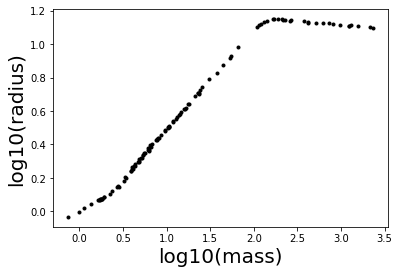

In [11]:
# determine the nominal minimum radius of any planet discovered by RVs
# use Chen & Kipping (2017) to convert mass to radius

rv_mass = d["mp"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err1 = d["merr1"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err2 = d["merr2"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err  = np.sqrt(rv_mass_err1**2 + rv_mass_err2**2)/np.sqrt(2)

bad = (rv_mass_err > 0.5*rv_mass) + np.isnan(rv_mass) + np.isnan(rv_mass_err)

rv_mass = rv_mass[~bad]
rv_mass_err = rv_mass_err[~bad]

rv_nominal_radius = np.zeros_like(rv_mass)
rv_stellar_radius = d["rs"][d["sys_disc_method"] == "Radial Velocity"][~bad]

for i, rvm in enumerate(rv_mass):
    rv_nominal_radius[i] = mr.Mstat2R(rvm, rv_mass_err[i], sample_size=1000)[0]

min_rv_radius = np.min(rv_nominal_radius[~np.isnan(rv_nominal_radius)])
    
nominal_rprs = (rv_nominal_radius*REARTH)/(rv_stellar_radius*RSUN)
min_rv_rprs = np.min(nominal_rprs[~np.isnan(nominal_rprs)])

plt.figure()
plt.plot(np.log10(rv_mass), np.log10(rv_nominal_radius), "k.")
plt.xlabel("log10(mass)", fontsize=20)
plt.ylabel("log10(radius)", fontsize=20)
plt.show()

In [12]:
# remove very small transiting planets (that wouldn't be discovered by RV)
# remove very long period RV planets (that wouldn't be discovered by Kepler)
# don't throw out the NaN values, which indicate missing data (e.g no radius for some RV planets)

d['rprs'] = (d['rp']*REARTH)/(d['rs']*RSUN)

keep = ((d["rprs"] >= min_rv_rprs) + np.isnan(d["rprs"])) * (d["p"] < 1460.)

for k in d.keys():
    d[k] = d[k][keep]

    
# recount the planets in each system and eliminate systems reduced to fewer than 3 planets
for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    

print("After removing long period and small radius objects, {0} planets in {1} systems remain"
      .format(len(d["starname"]), len(np.unique(d["starname"]))))

After removing long period and small radius objects, 701 planets in 202 systems remain


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


In [13]:
# recount the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 701 objects in 202 systems remain


# Forecast masses/radii for all of the planets

C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


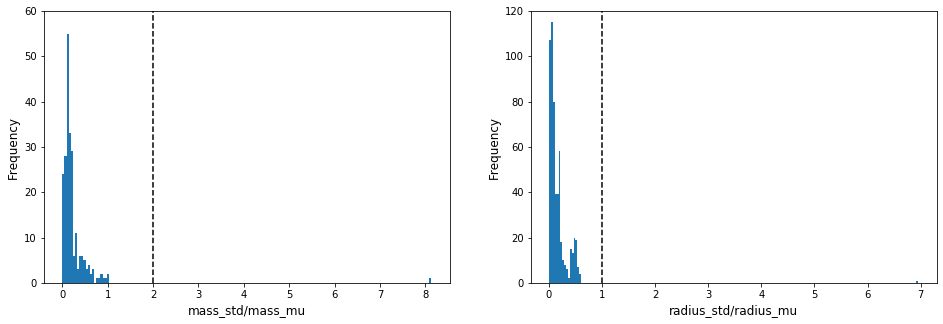

In [14]:
mass_mu = np.copy(d["mp"])
mass_std = np.sqrt(d["merr1"]**2 + d["merr2"]**2)/np.sqrt(2)

radius_mu = np.copy(d["rp"])
radius_std = np.sqrt(d["rerr1"]**2 + d["rerr2"]**2)/np.sqrt(2)

fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].hist(mass_std/mass_mu, bins = 'auto')
ax[0].set_xlabel('mass_std/mass_mu', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_ylim(0, 60)
ax[0].vlines(2, 0, 60, linestyles='dashed')

ax[1].hist(radius_std/radius_mu, bins = 'auto')
ax[1].set_xlabel('radius_std/radius_mu', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].vlines(1, 0, 120, linestyles='dashed')
ax[1].set_ylim(0, 120)
plt.show()

In [15]:
# replace absurdly large relatie errors with NaN
mass_std[mass_std/mass_mu > 2] = np.nan
radius_std[radius_std/radius_mu > 1] = np.nan

# fix values where mean mass exists but error does not
bad = ~np.isnan(mass_mu)*np.isnan(mass_std)
good = ~np.isnan(mass_mu)*~np.isnan(mass_std)
mass_std[bad] = mass_mu[bad]*np.max(mass_std[good]/mass_mu[good])

# fix values where mean radius exists but error does not
bad = ~np.isnan(radius_mu)*np.isnan(radius_std)
good = ~np.isnan(radius_mu)*~np.isnan(radius_std)
radius_std[bad] = radius_mu[bad]*np.max(radius_std[good]/radius_mu[good])

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
NPL = len(mass_mu)

mass_prob = np.zeros((NPL, NBOOT))
radius_prob = np.zeros_like(mass_prob)

for i in range(NPL):
    if i % 100 == 0:
        print(i)
    
    # no mass, no radius
    if np.isnan(mass_mu[i]) and np.isnan(radius_mu[i]):
        raise ValueError("All planets must have either a mass or radius (or both)")
    
    
    # mass measurement exists
    if ~np.isnan(mass_mu[i]):
        mass_prob[i] = stats.truncnorm((3e-4-mass_mu[i])/mass_std[i], (3e5-mass_mu[i])/mass_std[i], 
                                       loc=mass_mu[i], scale=mass_std[i]).rvs(NBOOT)
        
        if np.isnan(radius_mu[i]):
            radius_prob[i] = mr.Mpost2R(mass_prob[i])
        
    
    # radius measurement exists
    if ~np.isnan(radius_mu[i]):        
        radius_prob[i] = stats.truncnorm(0.1, 100, loc=radius_mu[i], scale=radius_std[i]).rvs(NBOOT)
        
        radius_prob[i] = stats.truncnorm((0.1-radius_mu[i])/radius_std[i], (100-radius_mu[i])/radius_std[i], 
                                       loc=radius_mu[i], scale=radius_std[i]).rvs(NBOOT)
        if np.isnan(mass_mu[i]):
            mass_prob[i] = mr.Rpost2M(radius_prob[i])

0


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


100
200
300
400
500
600
700


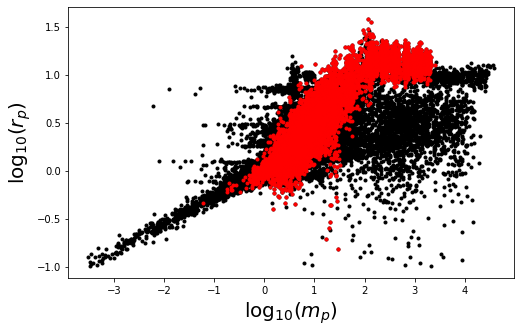

In [17]:
RV = d["disc_method"] == "Radial Velocity"

plt.figure(figsize=(8,5))
plt.plot(np.log10(mass_prob), np.log10(radius_prob), "k.")
plt.plot(np.log10(mass_prob)[RV], np.log10(radius_prob)[RV], "r.")
plt.xlabel("$\log_{10}(m_p)$", fontsize=20)
plt.ylabel("$\log_{10}(r_p)$", fontsize=20)
plt.show()

# Build list of systems

In [18]:
all_systems = []
transit_systems = []
rv_systems = []
mixed_systems = []

for i, star in enumerate(np.unique(d["starname"])):
    use = d["starname"] == star
    
    s = System()
    
    # stellar/system parameters
    s.starname = d["starname"][use][0]
    s.Mstar    = d["ms"][use][0]
    s.Rstar    = d["rs"][use][0]
    s.det_meth = d["sys_disc_method"][use][0]
        
    
    # measured planet properties
    s.rprs = d["rprs"][use]
    s.radii = d["rp"][use]
    s.masses = d['mp'][use]
    s.periods = d["p"][use]
    s.N = len(s.rprs)
    
    # arrays of probabilistic mass and radius
    s.prob_mass = mass_prob[use].swapaxes(0,1)
    s.prob_radius = radius_prob[use].swapaxes(0,1)
    
    # save to lists
    all_systems.append(s)
    
    if s.det_meth == "Transit":
        transit_systems.append(s)
    elif s.det_meth == "Radial Velocity":
        rv_systems.append(s)
    elif s.det_meth == "Mixed":
        mixed_systems.append(s)
    else:
        raise ValueError("Detection method must be 'Transit',  'Radial Velocity', or 'Mixed'")

# Assign weights to stellar masses

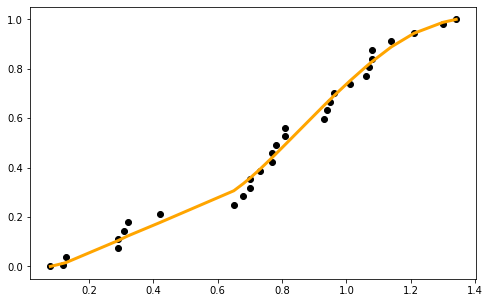

In [19]:
Mstar = []
starname = []
det_meth = []

for i, s in enumerate(all_systems):
    Mstar.append(s.Mstar)
    starname.append(s.starname)
    det_meth.append(s.det_meth)
    
    
Mstar = np.asarray(Mstar)
starname = np.asarray(starname)
det_meth = np.asarray(det_meth)

ms_rv = Mstar[det_meth == "Radial Velocity"]

# fraction of stellar masses (any detection method) beyond RV limit
# visual inspection reveals only a few transit stars with masses slightly beyond RV limits
low  = np.sum(Mstar < ms_rv.min())/len(Mstar)
high = np.sum(Mstar < ms_rv.max())/len(Mstar)

# generate a monotonic cubic spline (added noise prevents duplicate values)
train_x = np.sort(ms_rv + np.random.normal(loc=0, scale=100*sys.float_info.epsilon, size=len(ms_rv)))
train_x = np.hstack([Mstar.min(), train_x, Mstar.max()])

train_y = np.linspace(low, high, len(ms_rv))
train_y = np.hstack([0, train_y, 1])

spline = scipy.interpolate.PchipInterpolator(train_x, train_y)
#spline = scipy.interpolate.UnivariateSpline(train_x, train_y)

fit_x = np.linspace(train_x.min(), train_x.max(), 100)
fit_y = spline(fit_x)

# smooth the spline interpolation
win = sig.hann(49)
win /= np.sum(win)

fit_y_padded = np.pad(fit_y, (50,50), "edge")
fit_y_smooth = sig.convolve(fit_y_padded, win, "same")[50:-50]

# adjust so endpoints are at 0 and 1
fit_y_smooth = (fit_y_smooth-min(fit_y_smooth))/(max(fit_y_smooth)-min(fit_y_smooth))

# recalculate the spline on the smoothed values
spline = scipy.interpolate.PchipInterpolator(fit_x, fit_y_smooth)

# now determine weights for transit stars
ms_tr = Mstar[det_meth == "Transit"]
w_tr  = spline(ms_tr)

# make a plot
plt.figure(figsize=(8,5))
plt.plot(train_x, train_y, "ko")
plt.plot(train_x, spline(train_x), c="orange", lw=3)
plt.show()

# Now we can draw samples and compare cdfs

In [20]:
# dictionaries to hold p-values for Kolmogorov-Smirnov and Anderson-Darling tests
KS = {}
AD = {}

In [21]:
def perturbed_ks_2samp(x1, x2):
    n, m = len(x1), len(x2)
    
    D, p = stats.ks_2samp(x1, x2)

    eps_low  = np.min([D, 0.5/np.sqrt(n*m)])
    eps_high = np.min([1-D, 0.5/np.sqrt(n*m)])
    
    D_new = D + np.random.uniform(-eps_low, eps_high)
    p_new = 2*np.exp(-(2*m*D_new**2)/(1+m/n))
    
    return D_new, p_new

## Dynamical mass, $\mu$

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: p-value capped: true value larger than 0.25


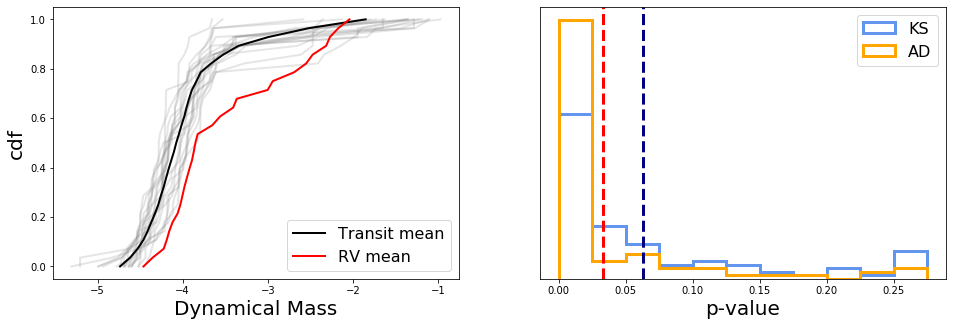

p_KS: 0.098
p_AD: 0.027


In [22]:
Nsys = len(ms_rv)

KS["mu"] = np.zeros(NBOOT)
AD["mu"] = np.zeros(NBOOT)

mu_rv = np.zeros((NBOOT,Nsys))
mu_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        mu_rv[i,j] = archinfo.mu(rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        mu_tr[i,j] = archinfo.mu(transit_systems[loc].prob_mass[i], transit_systems[loc].Mstar)

    mu_rv[i] = np.sort(mu_rv[i])
    mu_tr[i] = np.sort(mu_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["mu"][i] = np.min([perturbed_ks_2samp(mu_rv[i], mu_tr[i])[1], 0.25])
    AD["mu"][i] = stats.anderson_ksamp([mu_rv[i], mu_tr[i]])[2]
    
    KS["mu"][i] = np.max([KS["mu"][i], 1e-3])
    AD["mu"][i] = np.max([AD["mu"][i], 1e-3])


logmu_rv = np.log10(mu_rv)
logmu_tr = np.log10(mu_tr)


fig, ax = plt.subplots(1,2, figsize=(16,5))        

draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(logmu_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(logmu_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(logmu_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Dynamical Mass", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["mu"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["mu"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["mu"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["mu"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper right", fontsize=16)

plt.show()

KS_mean = stats.ks_2samp(np.mean(mu_tr,0), np.mean(mu_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(mu_tr,0), np.mean(mu_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))

## Normalized dynamical mass, $\mu/N$

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


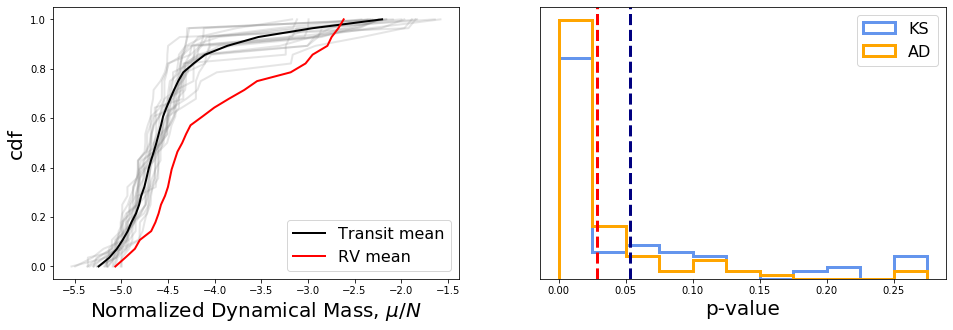

p_KS: 0.048
p_AD: 0.026


In [23]:
Nsys = len(ms_rv)

KS["mu_N"] = np.zeros(NBOOT)
AD["mu_N"] = np.zeros(NBOOT)

mu_N_rv = np.zeros((NBOOT,Nsys))
mu_N_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        mu_N_rv[i,j] = archinfo.mu(rv_systems[j].prob_mass[i], rv_systems[j].Mstar)/rv_systems[j].N
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        mu_N_tr[i,j] = archinfo.mu(transit_systems[loc].prob_mass[i], \
                                   transit_systems[loc].Mstar)/transit_systems[loc].N

    mu_N_rv[i] = np.sort(mu_N_rv[i])
    mu_N_tr[i] = np.sort(mu_N_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["mu_N"][i] = np.min([perturbed_ks_2samp(mu_N_rv[i], mu_N_tr[i])[1], 0.25])
    AD["mu_N"][i] = stats.anderson_ksamp([mu_N_rv[i], mu_N_tr[i]])[2]
    
    KS["mu_N"][i] = np.max([KS["mu_N"][i], 1e-3])
    AD["mu_N"][i] = np.max([AD["mu_N"][i], 1e-3])


logmu_N_rv = np.log10(mu_N_rv)
logmu_N_tr = np.log10(mu_N_tr)


fig, ax = plt.subplots(1,2, figsize=(16,5))        

draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(logmu_N_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(logmu_N_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(logmu_N_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Normalized Dynamical Mass, $\mu/N$", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["mu_N"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["mu_N"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["mu_N"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["mu_N"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper right", fontsize=16)

plt.show()

KS_mean = stats.ks_2samp(np.mean(mu_N_tr,0), np.mean(mu_N_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(mu_N_tr,0), np.mean(mu_N_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))

## Mass partitioning, Q

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: p-value capped: true value larger than 0.25


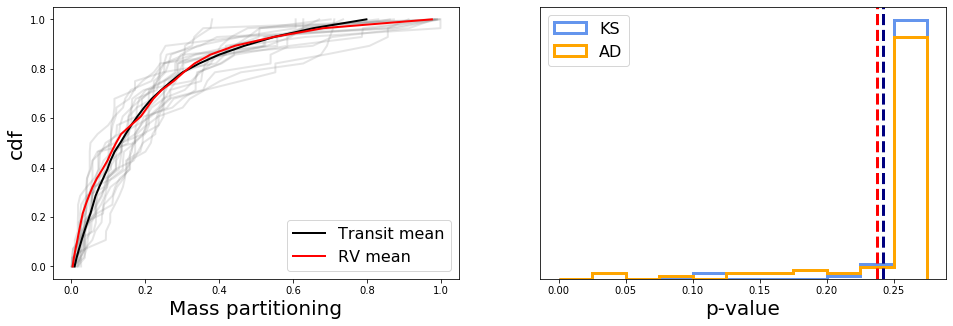

p_KS: 0.996
p_AD: 0.250


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: p-value capped: true value larger than 0.25


In [24]:
Nsys = len(ms_rv)

KS["Q"] = np.zeros(NBOOT)
AD["Q"] = np.zeros(NBOOT)

Q_rv = np.zeros((NBOOT,Nsys))
Q_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        Q_rv[i,j] = archinfo.Q(rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        
        Q_tr[i,j] = archinfo.Q(transit_systems[loc].prob_mass[i])


    Q_rv[i] = np.sort(Q_rv[i])
    Q_tr[i] = np.sort(Q_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["Q"][i] = np.min([perturbed_ks_2samp(Q_rv[i], Q_tr[i])[1], 0.25])
    AD["Q"][i] = stats.anderson_ksamp([Q_rv[i], Q_tr[i]])[2]
    
    KS["Q"][i] = np.max([KS["Q"][i], 1e-3])
    AD["Q"][i] = np.max([AD["Q"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(Q_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(Q_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(Q_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Mass partitioning", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["Q"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["Q"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["Q"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["Q"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()


KS_mean = stats.ks_2samp(np.mean(Q_tr,0), np.mean(Q_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(Q_tr,0), np.mean(Q_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))

## Monotonicity, M

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001


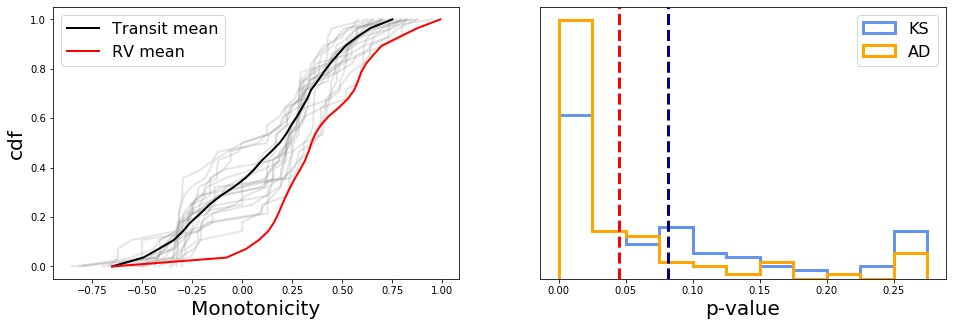

p_KS: 0.098
p_AD: 0.014


In [25]:
Nsys = len(ms_rv)

KS["M"] = np.zeros(NBOOT)
AD["M"] = np.zeros(NBOOT)

M_rv = np.zeros((NBOOT,Nsys))
M_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        M_rv[i,j] = archinfo.M(rv_systems[j].periods, rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        M_tr[i,j] = archinfo.M(transit_systems[loc].periods, transit_systems[loc].prob_mass[i])


    M_rv[i] = np.sort(M_rv[i])
    M_tr[i] = np.sort(M_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["M"][i] = np.min([perturbed_ks_2samp(M_rv[i], M_tr[i])[1], 0.25])
    AD["M"][i] = stats.anderson_ksamp([M_rv[i], M_tr[i]])[2]
    
    KS["M"][i] = np.max([KS["M"][i], 1e-3])
    AD["M"][i] = np.max([AD["M"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(M_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(M_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(M_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Monotonicity", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["M"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["M"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["M"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["M"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper right", fontsize=16)

plt.show()


KS_mean = stats.ks_2samp(np.mean(M_tr,0), np.mean(M_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(M_tr,0), np.mean(M_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))

## Gap complexity, C

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001


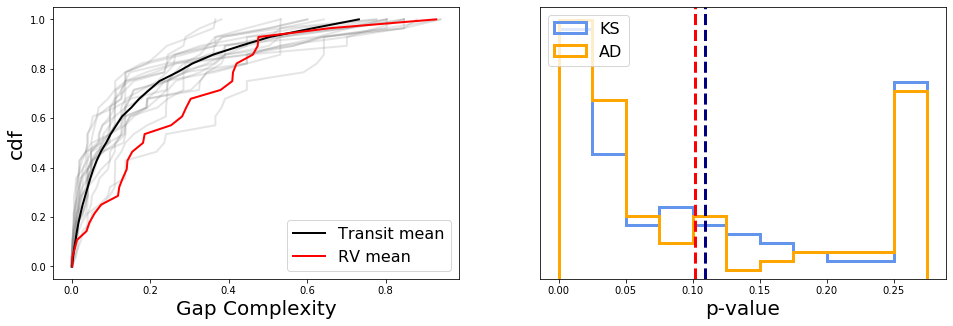

p_KS: 0.098
p_AD: 0.144


In [26]:
Nsys = len(ms_rv)

KS["C"] = np.zeros(NBOOT)
AD["C"] = np.zeros(NBOOT)

C_rv = np.zeros((NBOOT,Nsys))
C_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        C_rv[i,j] = archinfo.C(rv_systems[j].periods)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        C_tr[i,j] = archinfo.C(transit_systems[loc].periods)


    C_rv[i] = np.sort(C_rv[i])
    C_tr[i] = np.sort(C_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["C"][i] = np.min([perturbed_ks_2samp(C_rv[i], C_tr[i])[1], 0.25])
    AD["C"][i] = stats.anderson_ksamp([C_rv[i], C_tr[i]])[2]
    
    KS["C"][i] = np.max([KS["C"][i], 1e-3])
    AD["C"][i] = np.max([AD["C"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(C_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(C_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(C_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Gap Complexity", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["C"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["C"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["C"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["C"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()


KS_mean = stats.ks_2samp(np.mean(C_tr,0), np.mean(C_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(C_tr,0), np.mean(C_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))

## Characteristic Spacing, S

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: p-value capped: true value larger than 0.25


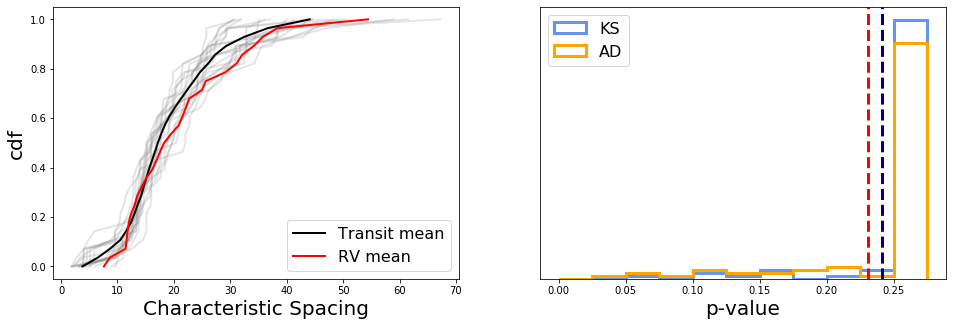

p_KS: 0.996
p_AD: 0.250


C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: p-value capped: true value larger than 0.25


In [27]:
Nsys = len(ms_rv)

KS["S"] = np.zeros(NBOOT)
AD["S"] = np.zeros(NBOOT)

S_rv = np.zeros((NBOOT,Nsys))
S_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        S_rv[i,j] = archinfo.S(rv_systems[j].periods, rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        S_tr[i,j] = archinfo.S(transit_systems[loc].periods, transit_systems[loc].prob_mass[i], 
                               transit_systems[loc].Mstar)


    S_rv[i] = np.sort(S_rv[i])
    S_tr[i] = np.sort(S_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["S"][i] = np.min([perturbed_ks_2samp(S_rv[i], S_tr[i])[1], 0.25])
    AD["S"][i] = stats.anderson_ksamp([S_rv[i], S_tr[i]])[2]
    
    KS["S"][i] = np.max([KS["S"][i], 1e-3])
    AD["S"][i] = np.max([AD["S"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(S_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(S_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(S_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Characteristic Spacing", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(0.0, 0.275, 12)

ax[1].hist(KS["S"], bins=bins, color="cornflowerblue", histtype="step", lw=3, label="KS")
ax[1].hist(AD["S"], bins=bins, color="orange", histtype="step", lw=3, label="AD")
ax[1].axvline(np.mean(KS["S"]), color="navy", lw=3, ls="--")
ax[1].axvline(np.mean(AD["S"]), color="red", lw=3, ls="--")
ax[1].set_xlabel("p-value", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()


KS_mean = stats.ks_2samp(np.mean(S_tr,0), np.mean(S_rv,0))[1]
AD_mean = stats.anderson_ksamp([np.mean(S_tr,0), np.mean(S_rv,0)])[2]

print("p_KS: {0:.3f}".format(KS_mean))
print("p_AD: {0:.3f}".format(AD_mean))